In [2]:
require(MathBioSim)
require(spatstat)
require(dplyr)
require(ggplot2)
require(foreach)
require(doParallel)

Loading required package: MathBioSim
Loading required package: Rcpp
Loading required package: devtools
Loading required package: spatstat
Loading required package: spatstat.data
Loading required package: nlme
Loading required package: rpart

spatstat 1.56-0       (nickname: 'Bondi Tram') 
For an introduction to spatstat, type 'beginner' 


Note: spatstat version 1.56-0 is out of date by more than 3 months; we recommend upgrading to the latest version.
Loading required package: dplyr

Attaching package: 'dplyr'

The following object is masked from 'package:nlme':

    collapse

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: foreach
Loading required package: doParallel
Loading required package: iterators
Loading required package: parallel


In [34]:
options(warn=-1)
registerDoParallel(makeCluster(detectCores() - 1))

sd_birth=seq(0.001,0.004,length.out = 7)
x_grid=seq(0,0.004*10,length.out=2001)

delta_time=250.0
n_samples=1000
time_start<-Sys.time()
pcf_est_av<-foreach(sd_birth_i = sd_birth, 
                    .combine = list,
                    .multicombine = TRUE)%do%{
require(MathBioSim)
require(spatstat)
require(dplyr)          
params<-list(
            "area_length_x"=10,    
            "cell_count_x"=100,  
               
            "b"=0.3,    
            "d"=0,    
            "dd"=0.001, 
               
            "seed"=1234,  
            "init_density"=100,
               
            "death_kernel_x"=x_grid,
            "death_kernel_y"=dnorm(x_grid,sd=0.002),
               
            "birth_kernel_x"=x_grid,
            "birth_kernel_y"=dnorm(x_grid,sd=sd_birth_i), 
               
            "spline_precision" = 1e-6  
            )

sim<-new(poisson_1d,params)
  
  
pop<-numeric(n_samples)
pcf_estimate<-list()
  
for(j in 1:n_samples){
    sim$run_for(delta_time)
    pop[j]=sim$total_population
    points<-unique.ppp(ppp(sim$get_all_coordinates(),
                           rep(0,sim$total_population),
                           c(0,10),c(-5,5)
                           )
                       )
    K_estimate<-Kest(points,r=x_grid,correction="Ripley")
    
    pcf_estimate[[j]]=data.frame(Kest=K_estimate$iso/2,x=x_grid)%>%
                      mutate(pfc=(Kest-lag(Kest))/(x_grid-lag(x_grid))/sim$area_length_x)%>%
                      pull(pfc)
  }
  
  pcf_est_av<-numeric(length(x_grid))
  for(j in 1:length(pcf_estimate[[1]])){
    jrow=numeric(n_samples)
    for (k in 1:n_samples){
      jrow[k]=pcf_estimate[[k]][j]
    }
    pcf_est_av[j]=mean(jrow)
  }
  
  list(pcf_est_av,pop)
}

print(Sys.time()-time_start)
options(warn=0)

Time difference of 5.139162 hours


In [35]:
options(repr.plot.width=20, repr.plot.height=10)

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

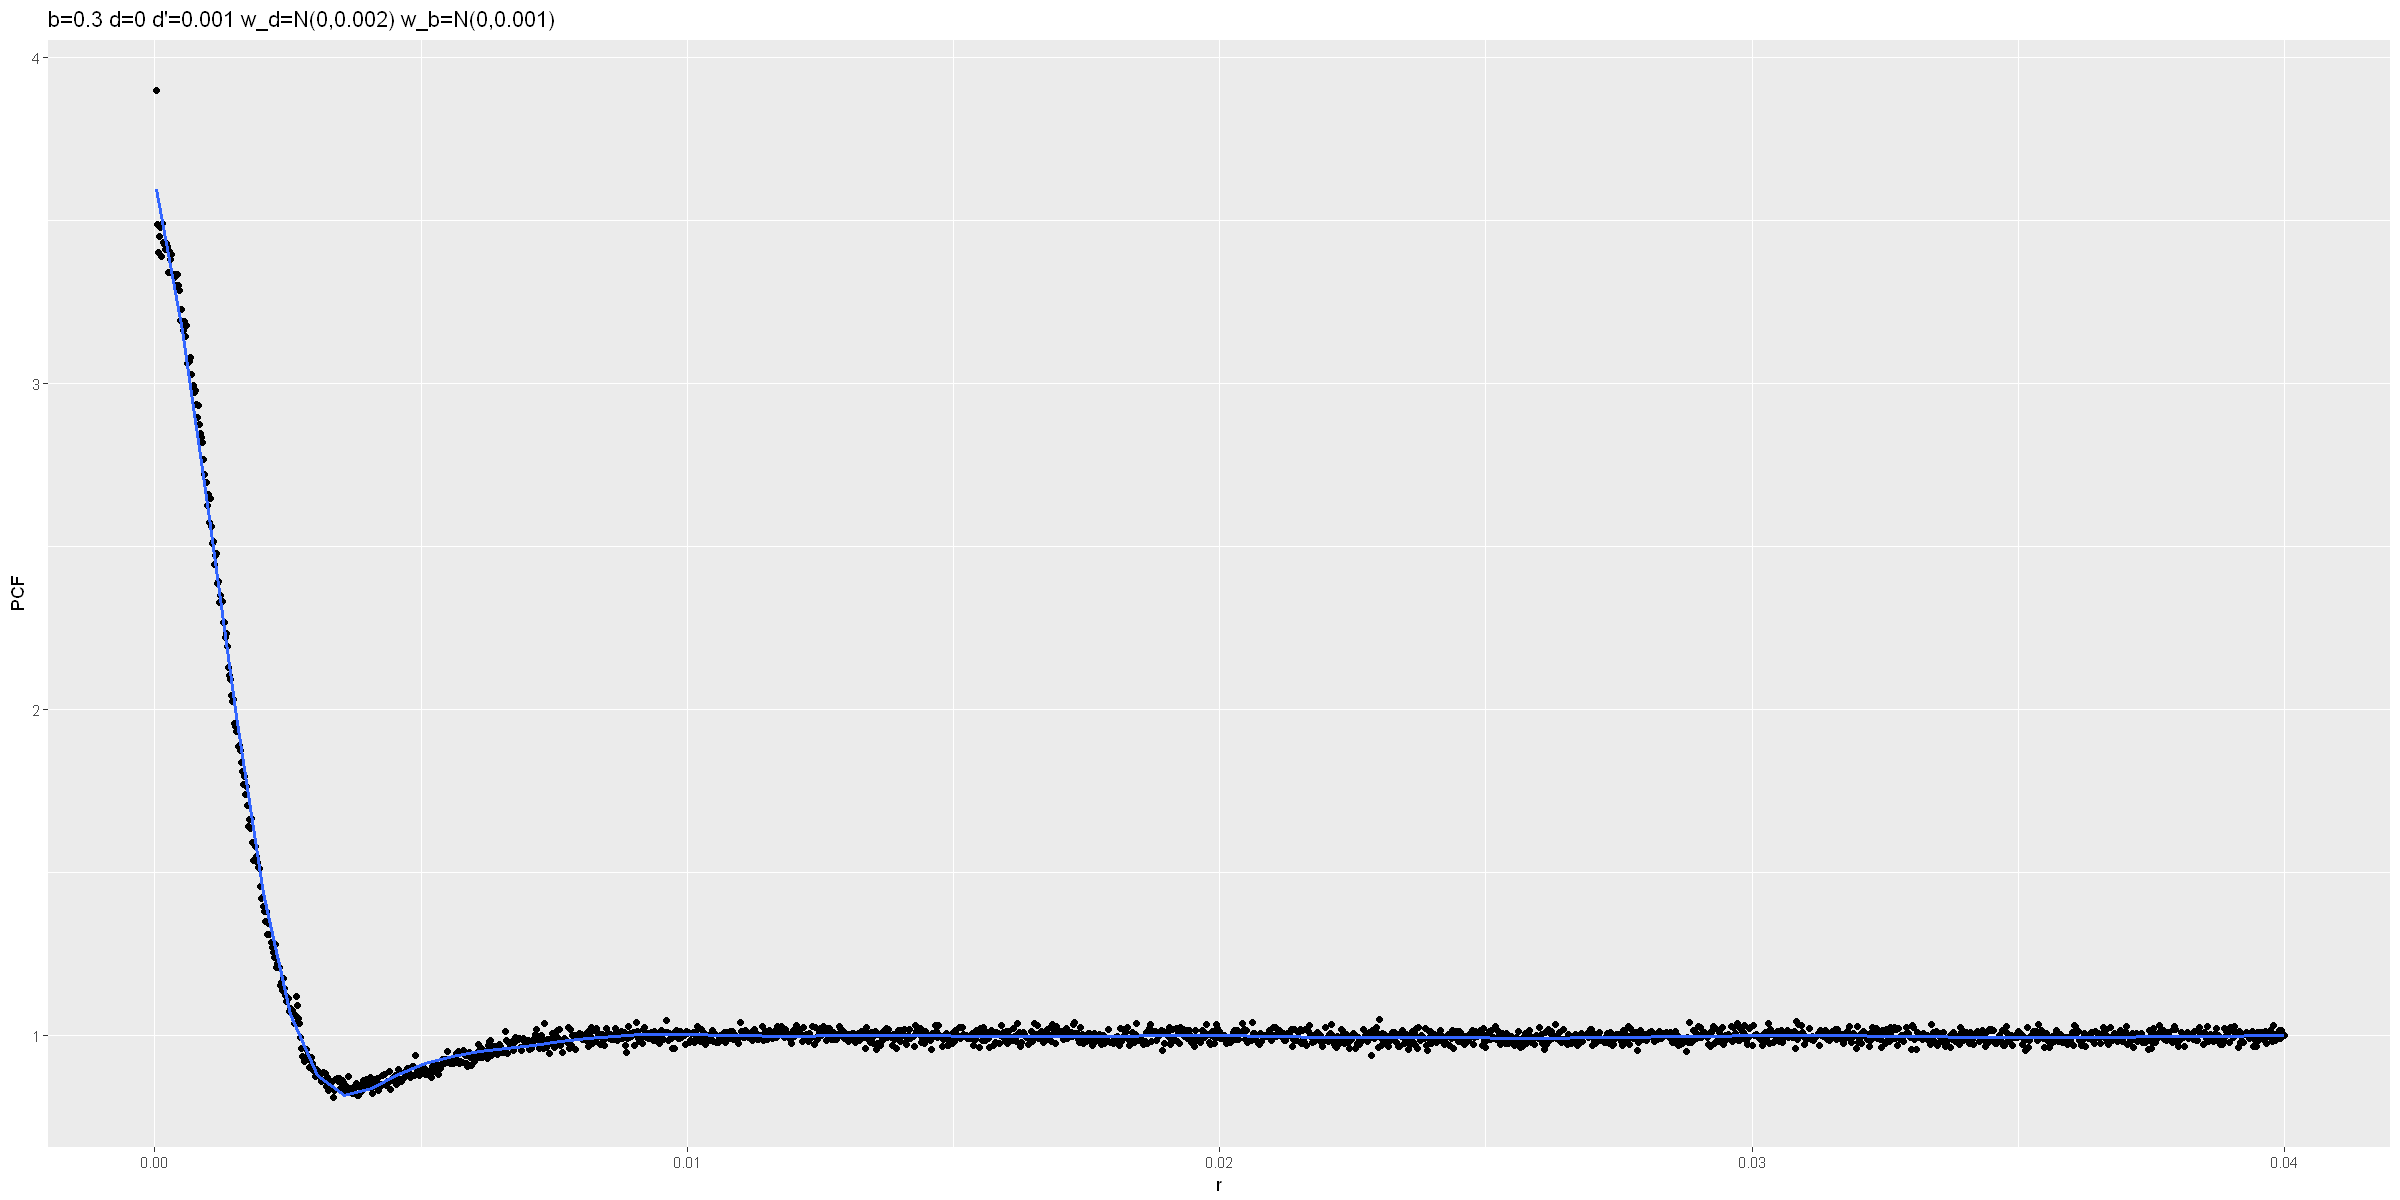

In [44]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[1]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.001)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

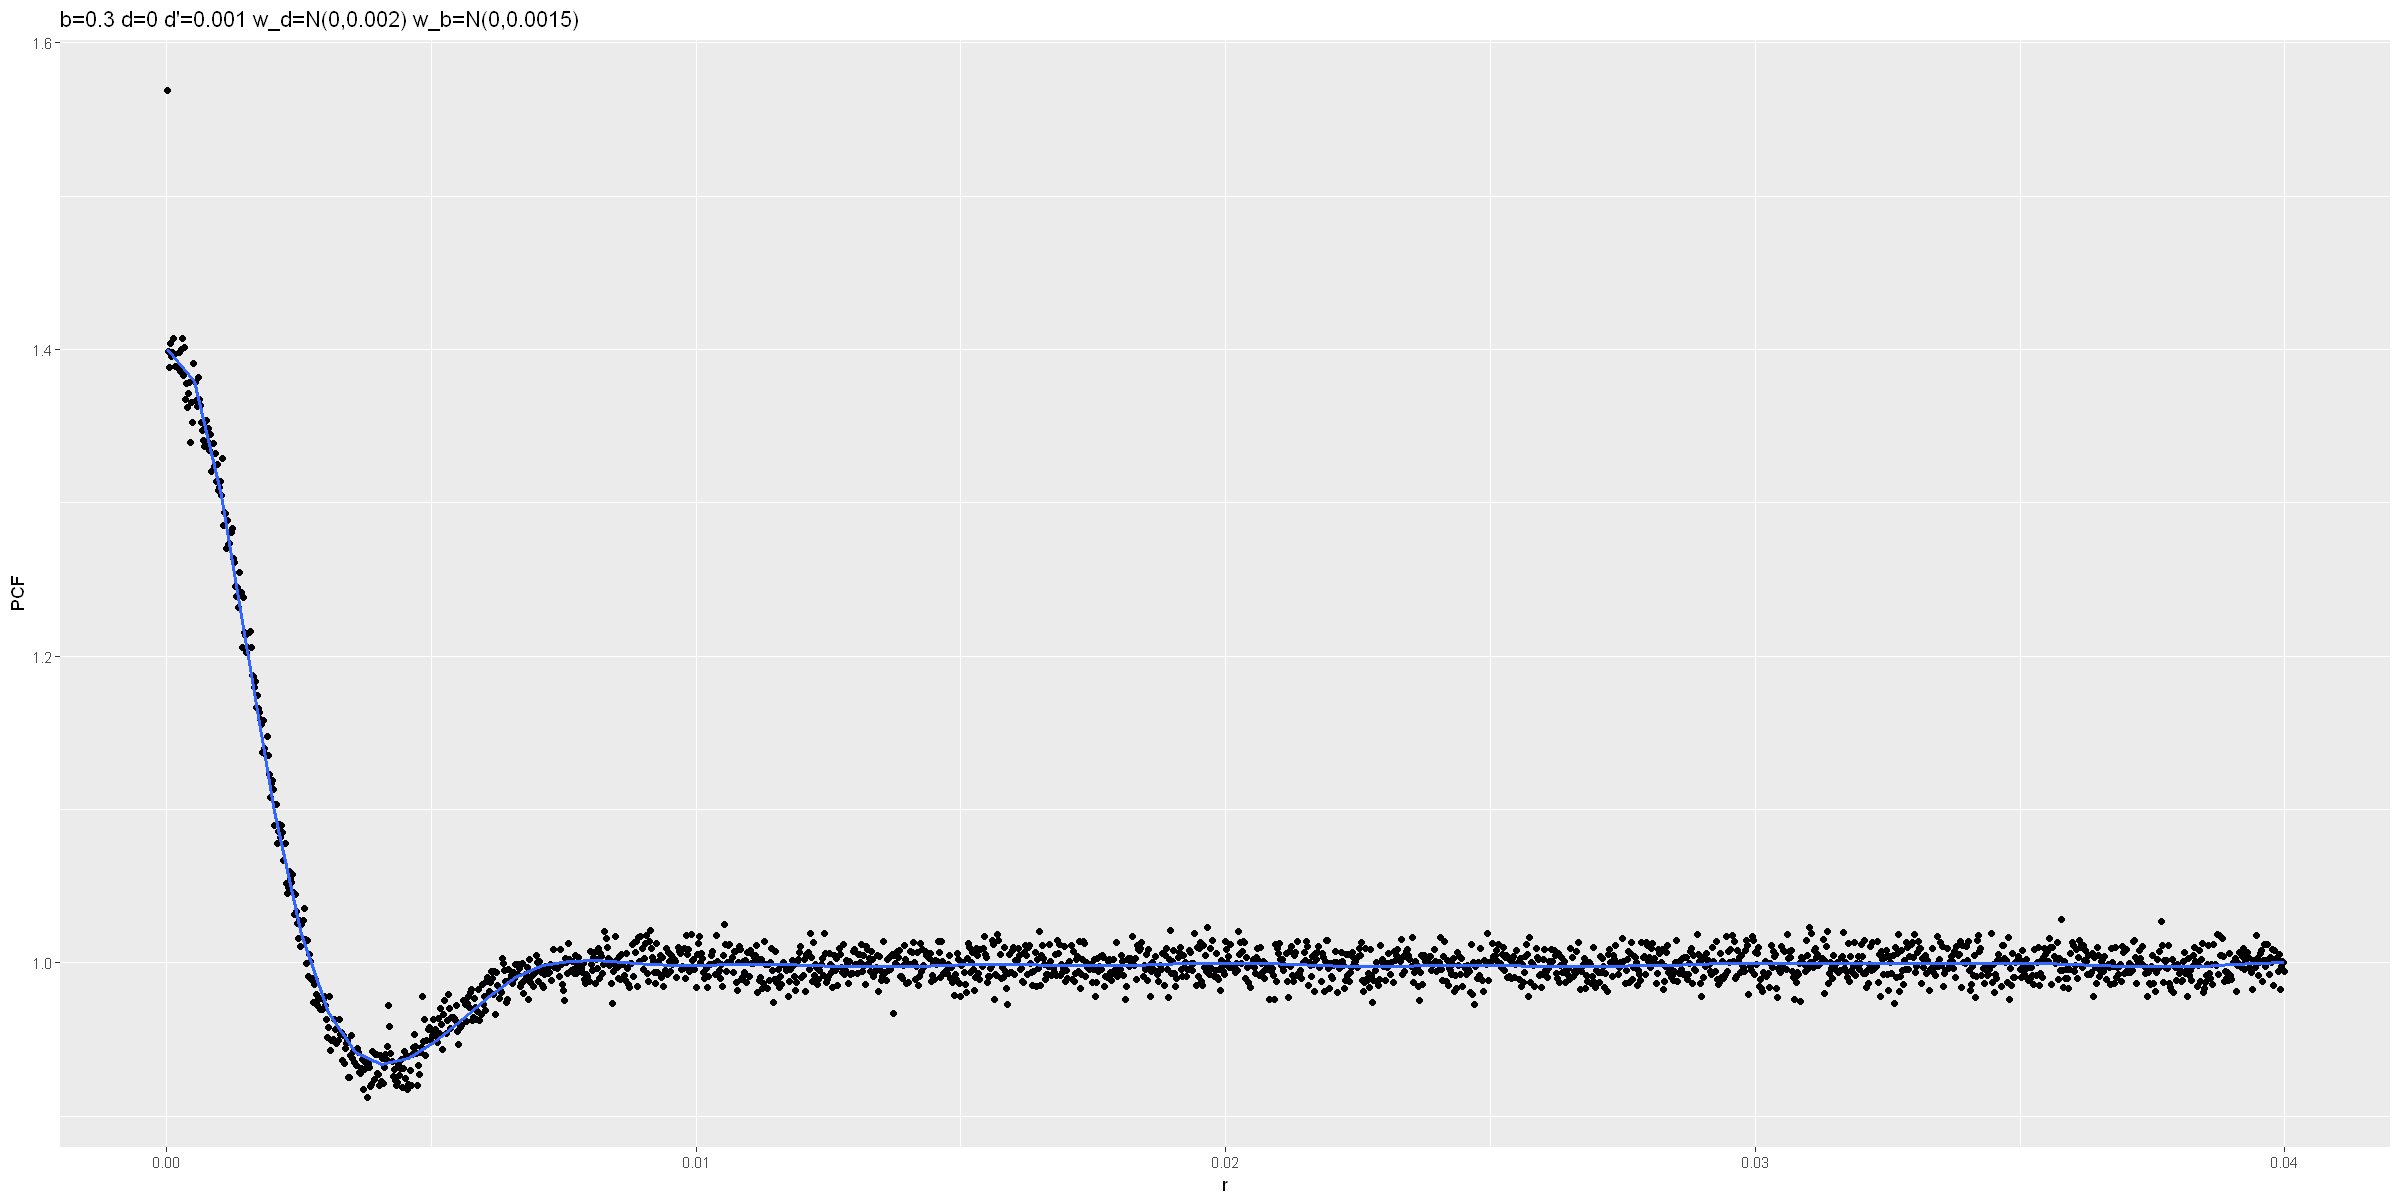

In [45]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[2]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.0015)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

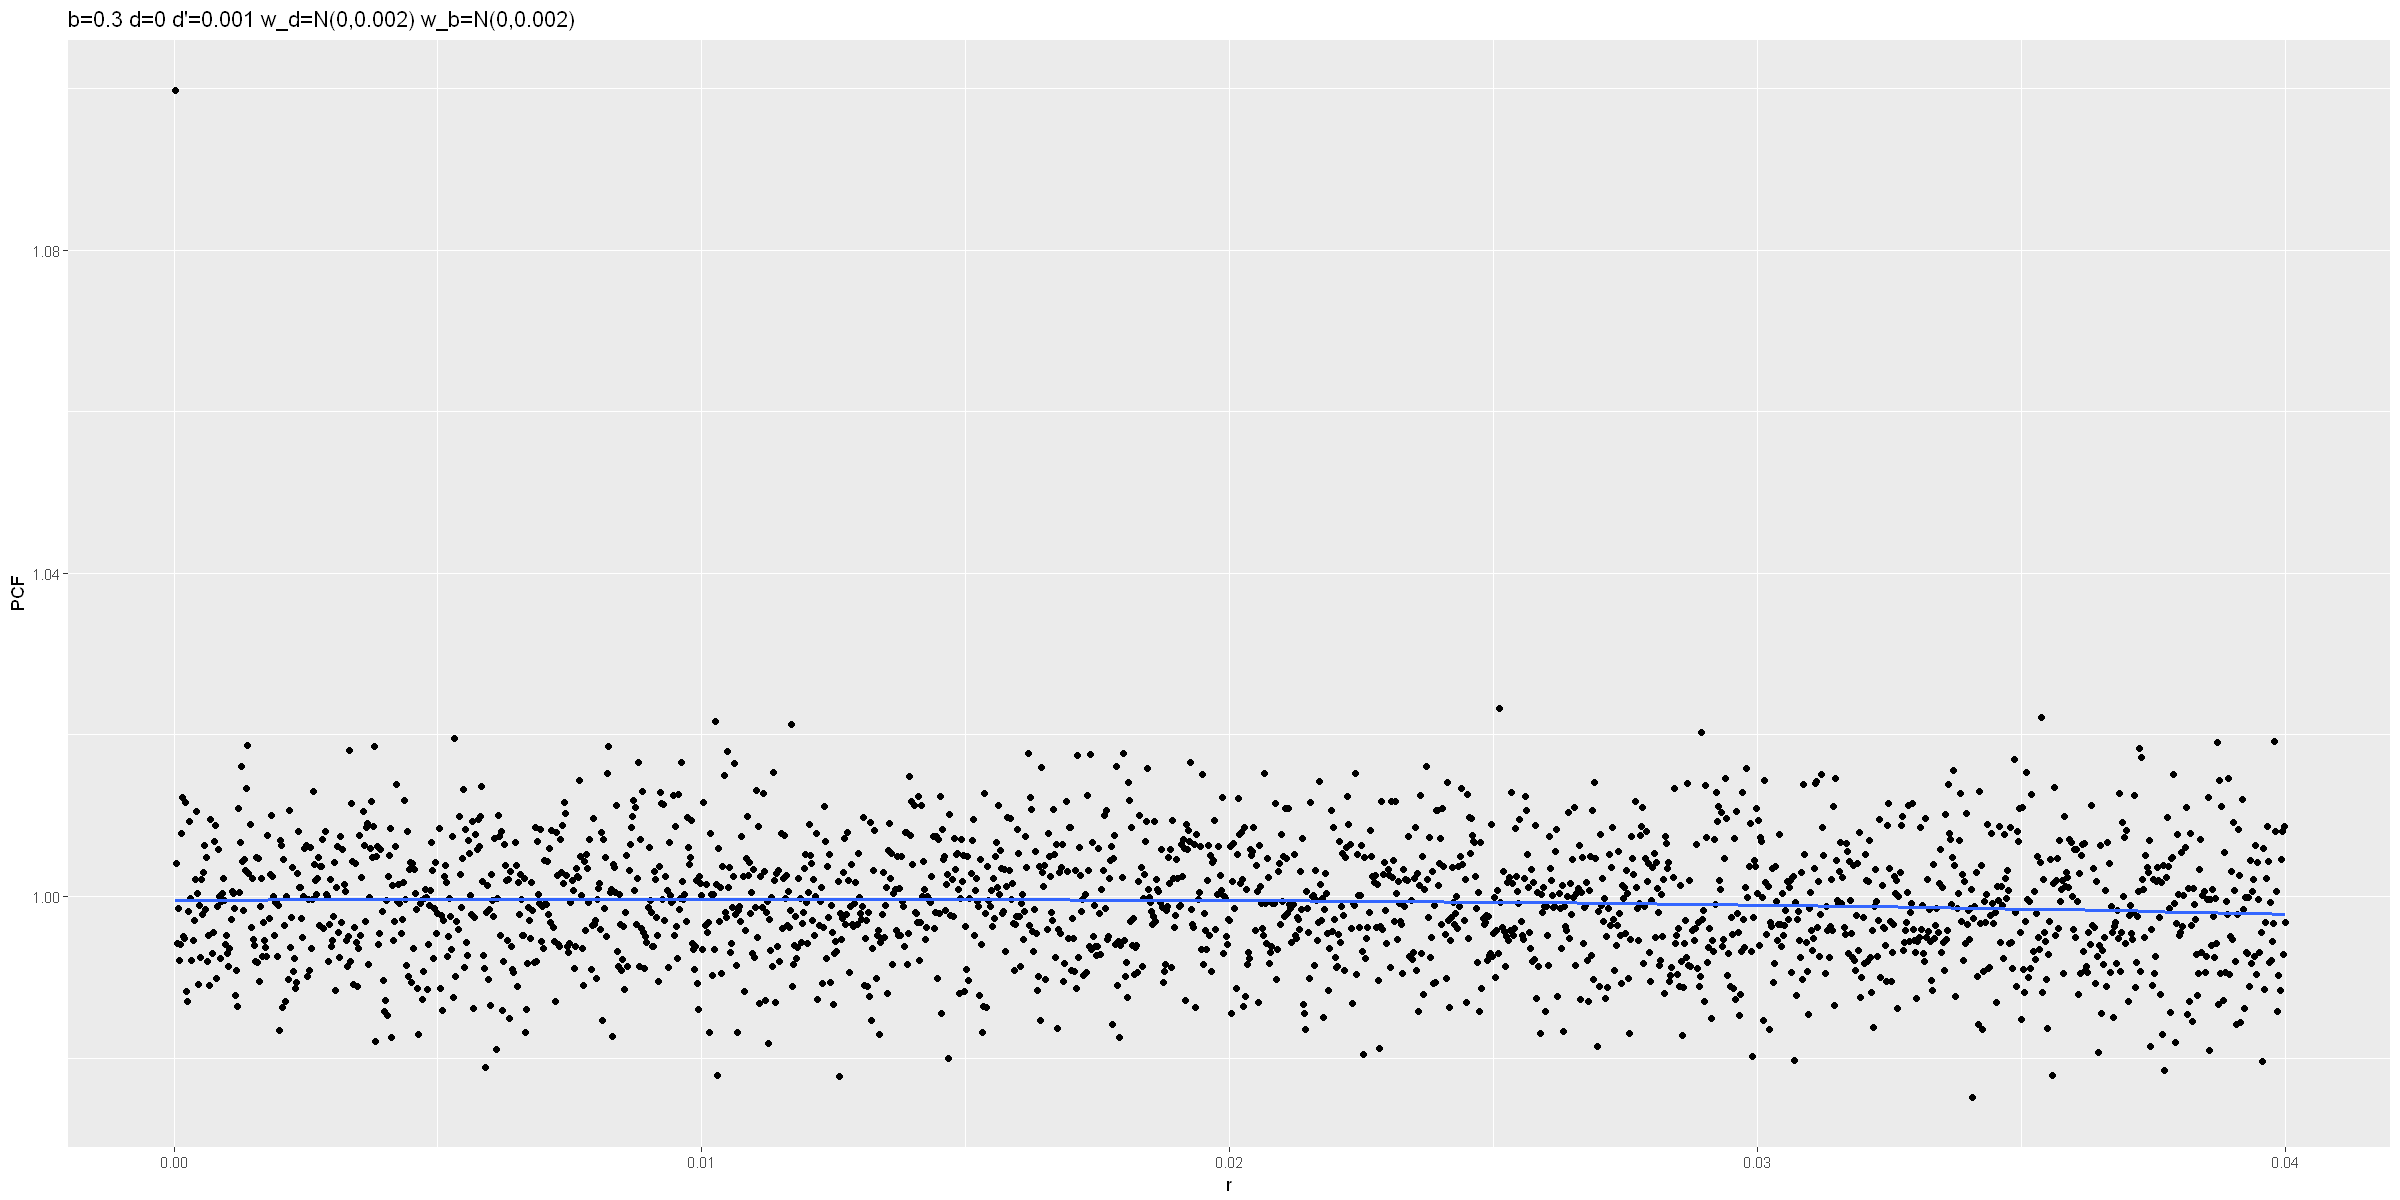

In [53]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[3]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 3), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.002)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

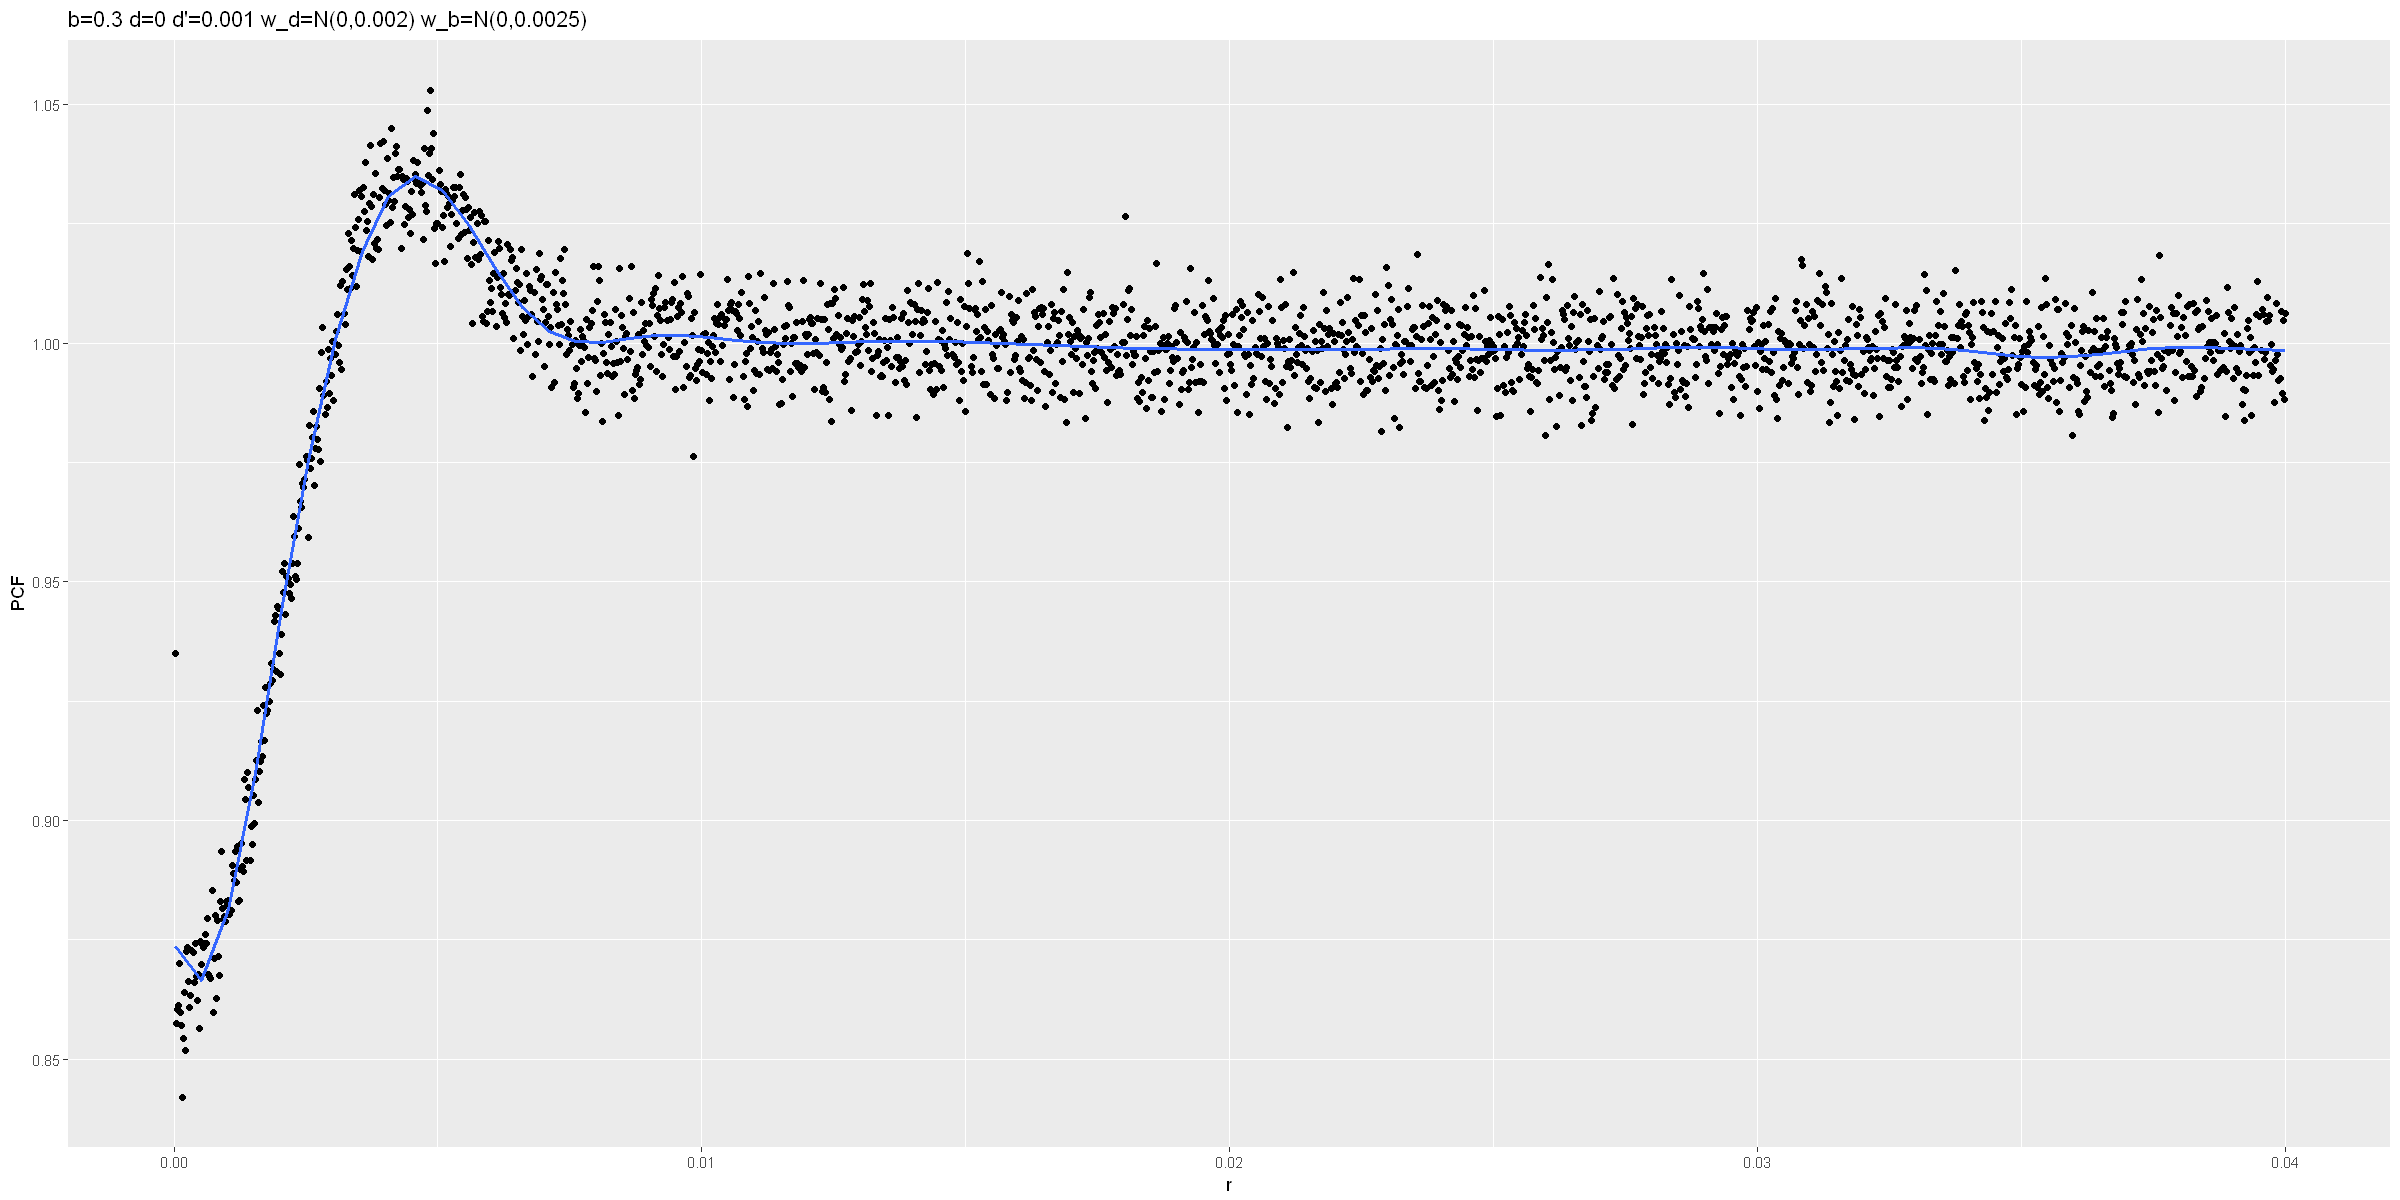

In [58]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[4]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.0025)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

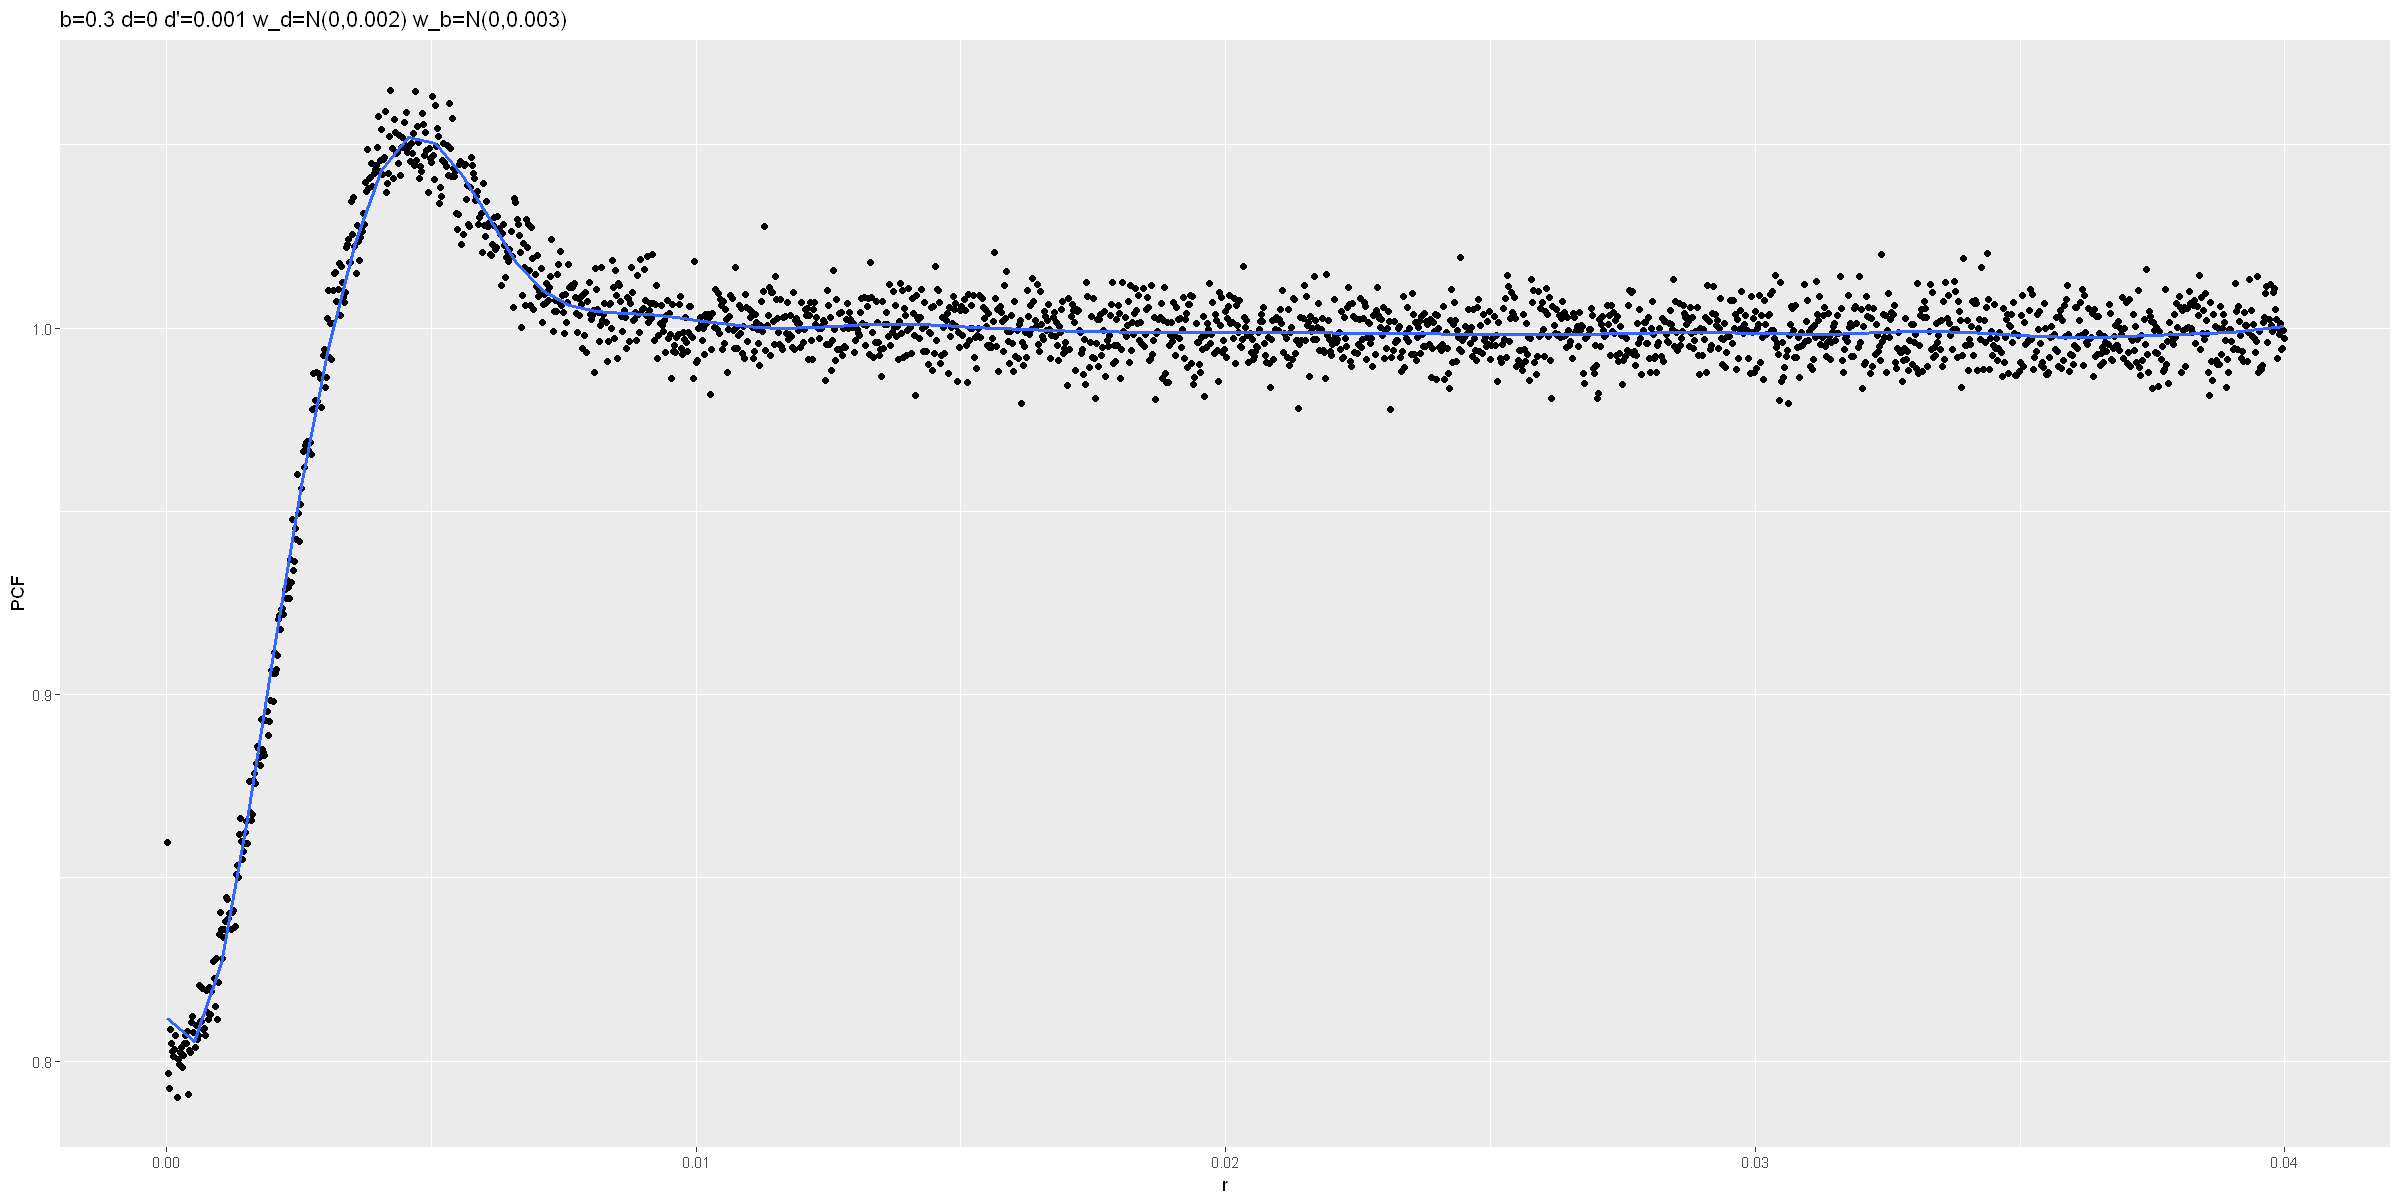

In [48]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[5]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.003)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

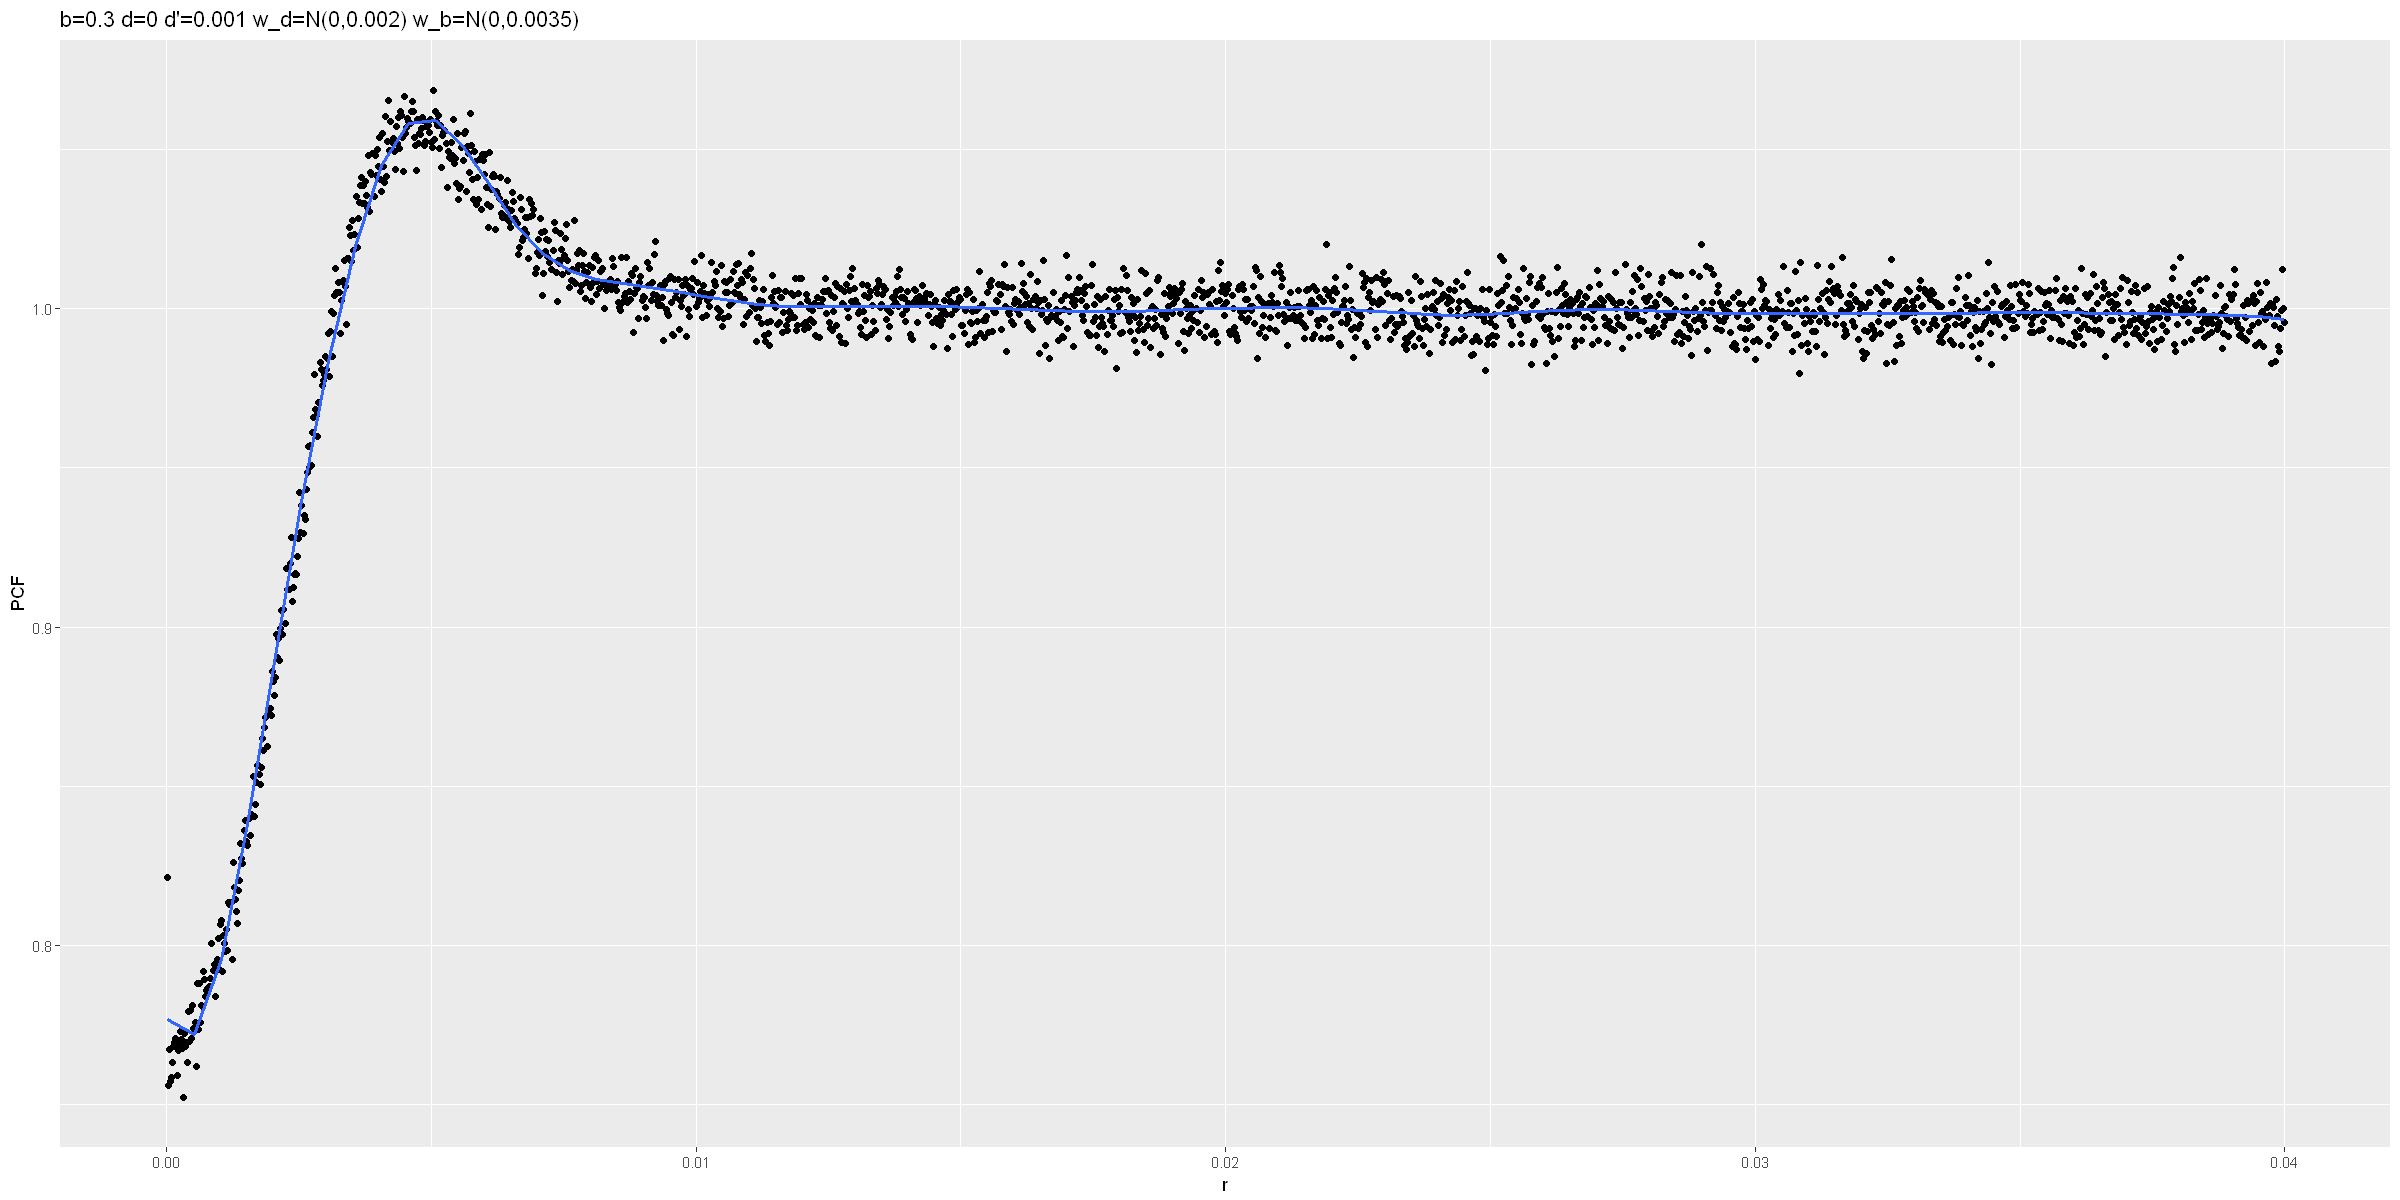

In [49]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[6]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.0035)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

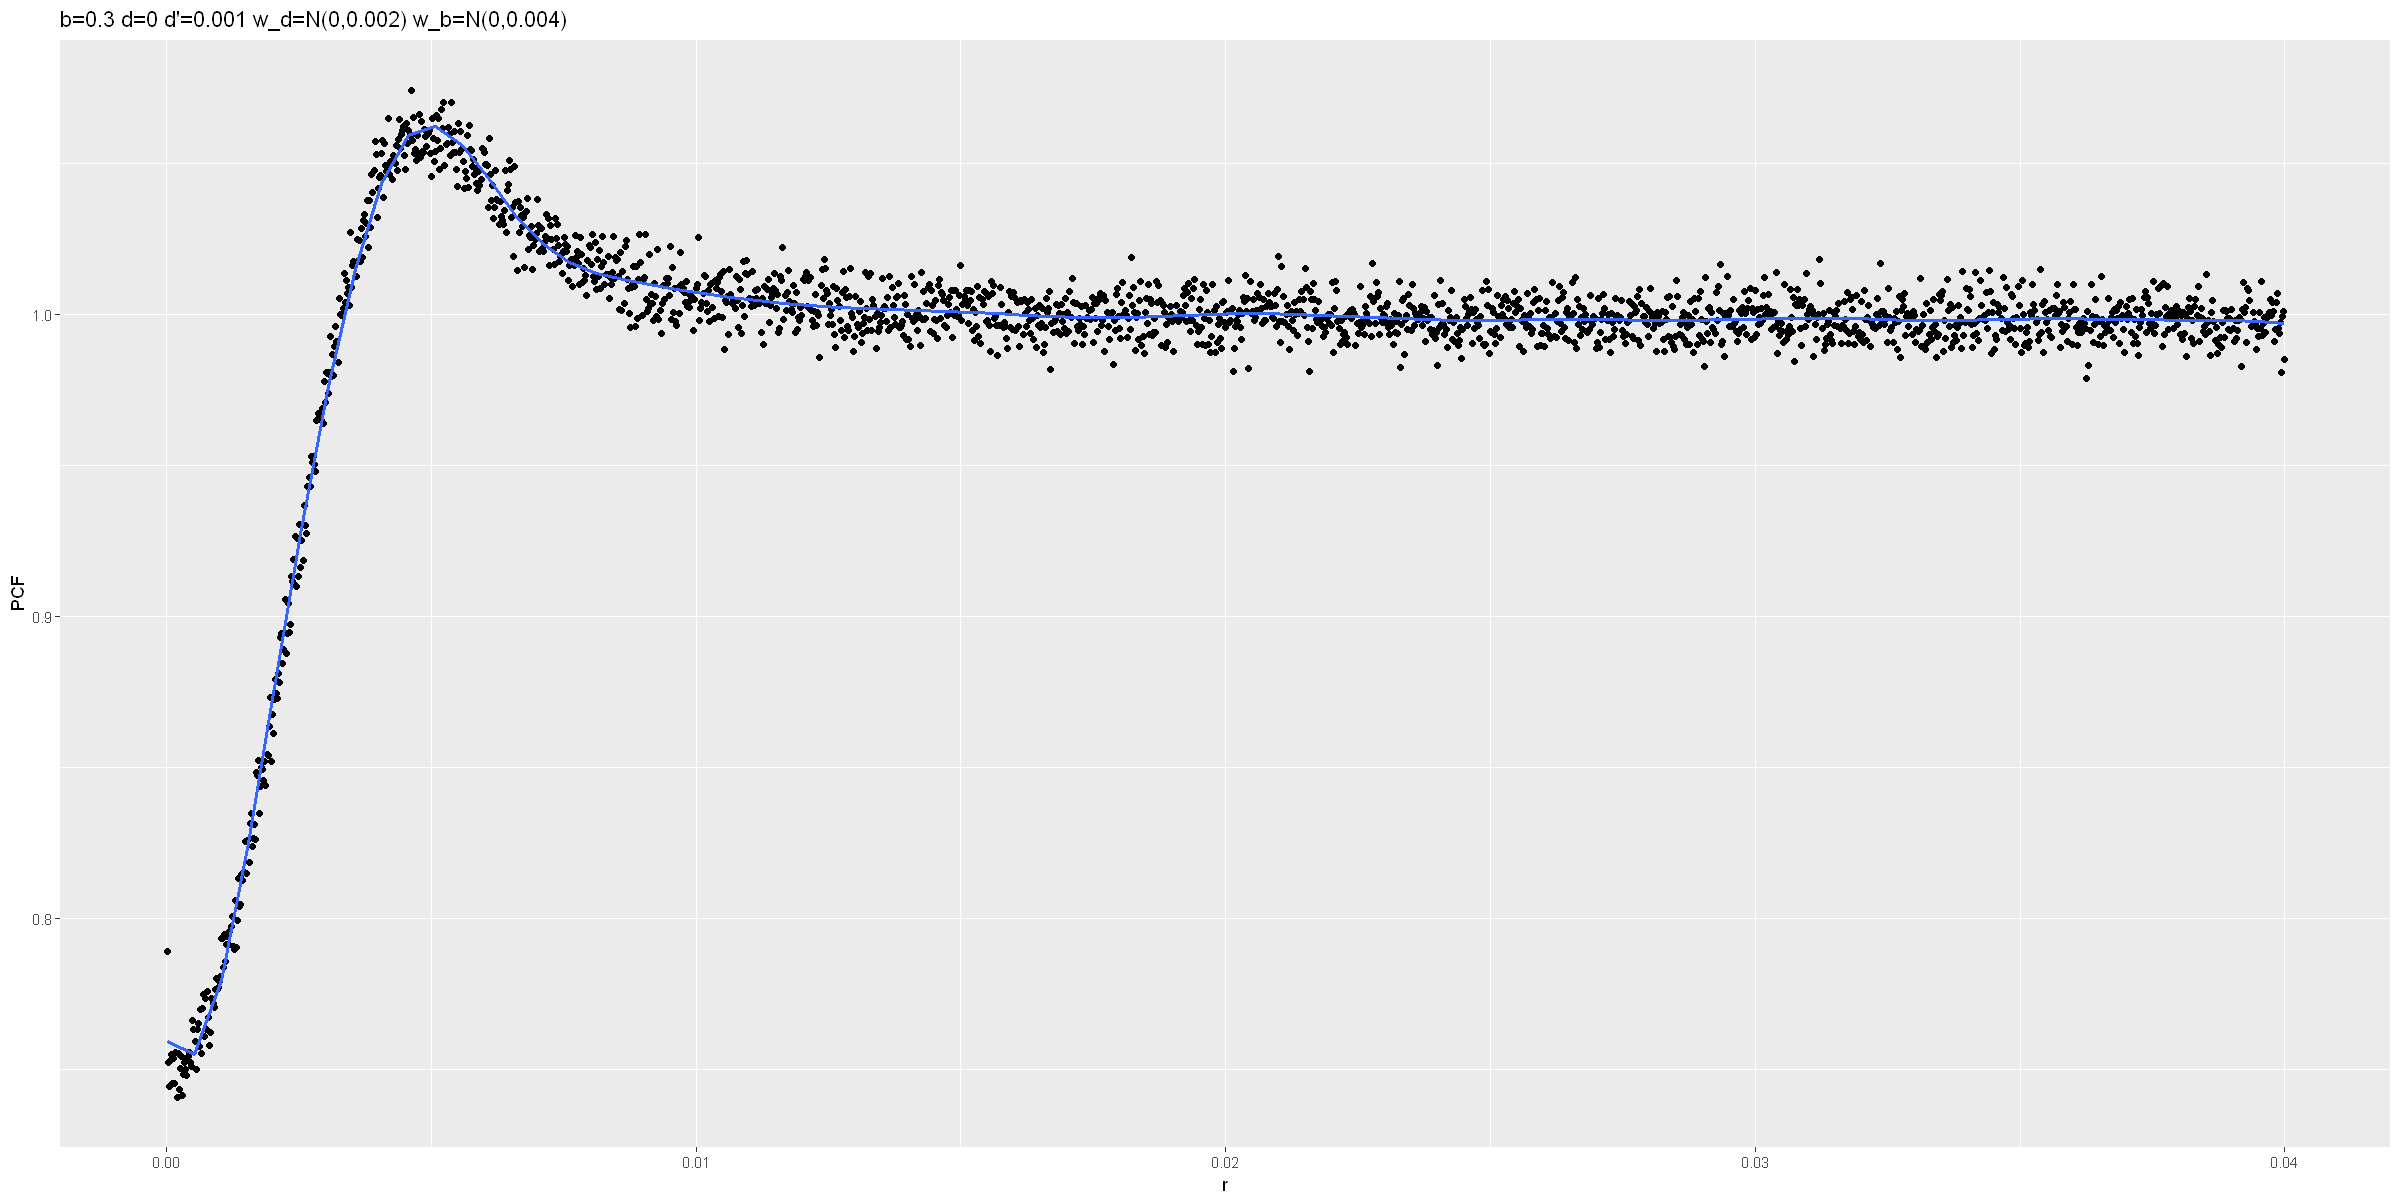

In [50]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[7]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.004)")

In [51]:
sapply(1:7,function(i){mean(pcf_est_av[[i]][[2]])})/10

[1] 139.2531 248.2167 299.4554 325.9790 340.7942 350.1771 356.2946

In [60]:
sapply(1:7,
       function(i){
           dif=pcf_est_av[[i]][[2]]-lag(pcf_est_av[[i]][[2]])
           print(t.test(dif)) 
                  } 
      )


	One Sample t-test

data:  dif
t = -0.032674, df = 998, p-value = 0.9739
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -3.850554  3.724428
sample estimates:
  mean of x 
-0.06306306 


	One Sample t-test

data:  dif
t = 0.019493, df = 998, p-value = 0.9845
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -4.589265  4.681357
sample estimates:
 mean of x 
0.04604605 


	One Sample t-test

data:  dif
t = 0.098758, df = 998, p-value = 0.9213
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -4.646698  5.139191
sample estimates:
mean of x 
0.2462462 


	One Sample t-test

data:  dif
t = 0.015702, df = 998, p-value = 0.9875
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -4.591771  4.665845
sample estimates:
 mean of x 
0.03703704 


	One Sample t-test

data:  dif
t = 0.0042686, df = 998, p-value = 0.9966
alternative hypothesis: true mean is not 

statistic,-0.03267372,0.01949344,0.09875849,0.01570154,0.004268633,-0.02293429,0.01175707
parameter,998,998,998,998,998,998,998
p.value,0.9739413,0.9844514,0.9213499,0.9874756,0.996595,0.9817073,0.9906218
conf.int,"-3.850554, 3.724428","-4.589265, 4.681357","-4.646698, 5.139191","-4.591771, 4.665845","-4.591717, 4.611737","-4.852423, 4.740311","-4.650064, 4.706120"
estimate,-0.06306306,0.04604605,0.2462462,0.03703704,0.01001001,-0.05605606,0.02802803
null.value,0,0,0,0,0,0,0
alternative,two.sided,two.sided,two.sided,two.sided,two.sided,two.sided,two.sided
method,One Sample t-test,One Sample t-test,One Sample t-test,One Sample t-test,One Sample t-test,One Sample t-test,One Sample t-test
data.name,dif,dif,dif,dif,dif,dif,dif
